# Story Generator HP Lovecraft using Transformer between Greedy and Beam Search

In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import random, math, time
from torch.autograd import Variable
import operator

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


cuda:0


## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [2]:
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

import os 
path = './datasets/HPLoveCraft/' # assign directory
hp_files = [os.path.join(path, filename) for filename in os.listdir(path)]
len(hp_files) #102 story!!!

102

In [3]:
#extract .txt out
import os
import glob
import pandas as pd
import re
# Path to folder containing text files
directory = path

data = []
# Loop through all files in directory
for filename in os.listdir(directory):
    # Check if file is a CSV file
    if filename.endswith(".txt"):
        with open(os.path.join(directory, filename), "r", encoding="utf8") as file:
            #preprocessing
            lines = file.read()
            # lines = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', lines)
            lines = re.split(r"[-;.\n]",lines)
            story = [line.strip() for line in lines if line != '']
            
            data.append({'title': filename, 'story': story})
            
df_lovecraft = pd.DataFrame(data)
df_lovecraft.head()

,title,story
0,Azathoth.txt,"[Azathoth, When age fell upon the world, and w..."
1,Celepha├»s.txt,"[Celephaïs, In a dream Kuranes saw the city in..."
2,Collapsing_Cosmoses.txt,"[Collapsing Cosmoses, [Note: Barlow’s contribu..."
3,Beyond_the_Wall_of_Sleep.txt,"[Beyond the Wall of Sleep, “I have an expositi..."
4,Cool_Air.txt,"[Cool Air, You ask me to explain why I am afra..."


In [4]:
df_lovecraft.shape

(102, 2)

In [5]:
storys = df_lovecraft['story'].values.tolist()
len(storys)

102

In [6]:
text_story = [line for story in storys for line in story]
len(text_story)

156141

In [7]:
max_string_length = max(text_story, key=len)
len(max_string_length),max_string_length #without preprocessing

(134,
 'I am desirous you will Acquaint me with what ye Blacke Man learnt from Sylvanus Cocidius in ye Vault, under ye Roman Wall, and will be')

In [8]:
from sklearn.model_selection import train_test_split

# assume `df` is your Pandas dataframe
# split into train and test/validation
train_split, test_val_df = train_test_split(text_story, test_size=0.3, random_state=555)
# split test/validation into test and validation sets
test_split, val_split = train_test_split(test_val_df, test_size=0.5, random_state=555)

In [9]:
len(train_split), len(val_split), len(test_split)

(109298, 23422, 23421)

## 2. Preprocessing

### Tokenizing

Simply tokenize the given text to tokens.

In [10]:
from torchtext.data.utils import get_tokenizer
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

tokenized_dataset_train = yield_tokens(train_split)
tokenized_dataset_val = yield_tokens(val_split)
tokenized_dataset_test = yield_tokens(test_split)

In [11]:
# max_token = max(tokenized_dataset_train, key=len)
# print(len(max_token))
# print(max_token)  #without preprocessing

In [12]:
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
import re

nlp = spacy.load('en_core_web_sm')

def preprocessing(sentence):
    
    # Clear the html tag by using regular expression.
    sentence = re.sub("<[^>]*>", "", sentence)
    sentence = re.sub("[^\x00-\x7F]+", "", sentence) #extract non-english out
    #It matches any character which is not contained in the ASCII character set (0-127, i.e. 0x0 to 0x7F)
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM' and token.pos_!= 'X':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

### Numericalizing

We will tell torchtext to add any word that has occurred at least three times in the dataset to the vocabulary because otherwise it would be too big.  Also we shall make sure to add `unk` and `eos`.

In [13]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [14]:
# from torchtext.vocab import build_vocab_from_iterator
# def yield_tokens(data_iter):
#     for text in data_iter:
#         yield tokenizer(preprocessing(text))

# vocab_transform = build_vocab_from_iterator(yield_tokens(train_split), 
#                                   min_freq=2,
#                                   specials=special_symbols,
#                                   special_first=True)
        
# vocab_transform.set_default_index(UNK_IDX)   
# print('Vocab Size',len(vocab_transform))                         
# print(vocab_transform.get_itos()[:10])       

In [15]:
import pickle
# with open('vocab_transform_hp.pickle', 'wb') as f:
#     pickle.dump(vocab_transform, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('vocab_transform_hp.pickle', 'rb') as f:
    vocab_transform = pickle.load(f)
    
print('Vocab Size',len(vocab_transform))                         
print(vocab_transform.get_itos()[:10])       

Vocab Size 20072
['<unk>', '<pad>', '<sos>', '<eos>', 'i', 'the', 'know', 'man', 'it', 'thing']


## 3. Prepare the batch loader

### Prepare data

Given "Chaky loves eating at AIT", and "I really love deep learning", and given batch size = 3, we will get three batches of data "Chaky loves eating at", "AIT `<eos>` I really", "love deep learning `<eos>`".  

In [16]:
def get_data(dataset, vocab, batch_size):
    data = []                                                   
    for example in dataset:       
        #appends eos so we know it ends....so model learn how to end...                             
        tokens = example.append('<eos>') #end of sentence
        #numericalize          
        tokens = [vocab[token] for token in example] 
        data.extend(tokens)                                    
    data = torch.LongTensor(data)                                 
    num_batches = data.shape[0] // batch_size 
    data = data[:num_batches * batch_size]                       
    data = data.view(batch_size, num_batches)        
    return data

In [17]:
batch_size = 64
train_data = get_data(tokenized_dataset_train, vocab_transform, batch_size)
valid_data = get_data(tokenized_dataset_val, vocab_transform, batch_size)
test_data  = get_data(tokenized_dataset_test, vocab_transform, batch_size)
train_data.shape,valid_data.shape,test_data.shape #[batch_size, all the next length]

(torch.Size([64, 17920]), torch.Size([64, 3826]), torch.Size([64, 3832]))

## 5. Design the model

### Remove Encoder and Encoder Layer

### Mutli Head Attention Layer

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

In [18]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads #make sure it's divisible....

        self.fc_q = nn.Linear(hid_dim,hid_dim) 
        self.fc_k = nn.Linear(hid_dim,hid_dim) 
        self.fc_v = nn.Linear(hid_dim,hid_dim) 

        self.fc = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, q, k, v, mask = None):
        batch_size = q.shape[0]
        
        Q = self.fc_q(q)
        K = self.fc_k(k)
        V = self.fc_v(v)
        
        #Q, K, V = [b, l, h]
        #reshape them into head_dim
        #reshape them to [b, n_headm, l, head_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        #Q, K, V = [b, m_head, l, head_dim]

        #e = QK/sqrt(dk)
        e =  torch.matmul(Q, K.permute(0,1,3,2)) / self.scale
        #e = [b, n_heads, ql, kl]
        
        # torch.Size([64, 8, 50, 50])
        # torch.Size([64, 1, 1, 50, 256])

        if mask is not None:
            e = e.masked_fill(mask == 0, -1e10)

        a = torch.softmax(e, dim=-1)
        #a = [batch size, n_heads, ql, kl]
                    
        #eV
        x = torch.matmul(self.dropout(a),V)
        #x : [b, n_heads, ql, head_di]

        x = x.permute(0, 2, 1, 3).contiguous()
        #x: [b, ql, n_heads, head_dim]

        #concat them together
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [b, ql, h]

        x = self.fc(x)
        #x = [b, ql, h]

        return x, a

### Position-wise Feedforward Layer

In [19]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder Layer

<img src = "./figures/GPT-1.png" width=400>

In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()

        self.norm_ff = nn.LayerNorm(hid_dim) #second yellow box
        self.norm_maskedatt = nn.LayerNorm(hid_dim) #first red box
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.ff = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, trg_mask):
        #trg      : [b, l, h]
        #enc_src  : [b, sl, h]
        #trg_mask : [b, 1, tl, tl]
        #src_mask : [b, 1, 1, sl]

        #1st box : mask multi, add & norm
        _trg, attention = self.self_attention(trg, trg, trg, trg_mask) #Q, K, V
        _trg    = self.dropout(_trg)
        _trg    = trg + _trg
        trg     = self.norm_maskedatt(_trg)

        #2rd box : ff, add & norm
        _trg    = self.ff(trg)
        _trg    = self.dropout(_trg)
        _trg    = trg + _trg
        trg     = self.norm_ff(_trg)

        return trg, attention

### Decoder

In [700]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device, src_pad_idx,trg_pad_idx, max_length = 100):
        super().__init__()
        self.pos_emb = nn.Embedding(max_length, hid_dim)
        self.trg_emb = nn.Embedding(output_dim, hid_dim)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList(
                            [
                            DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                            for _ in range(n_layers)
                            ]
                            )
        self.fc = nn.Linear(hid_dim, output_dim)
        self.device = device
        
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

    def make_src_mask(self, src):
        #src = [batch size, src len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_mask : [batch size, 1, 1, trg len]
        
        trg_len = trg_mask.shape[-1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device =self.device)).bool() #lower triangle
        #trg_sub_mask = [trg len, trg len]
        trg_mask = trg_mask & trg_sub_mask 
        #trg_mask : [batch size, 1, trg len, trg len]
        return trg_mask     
    
    def forward(self, x):
        #src : = [batch size, trg len]
        #enc_src : hidden state from encoder = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = x.shape[0]
        trg_len = x.shape[1]
        
        trg_mask = self.make_trg_mask(x)

        #pos
        pos = torch.arange(0,trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, trg len]

        pos_emb = self.pos_emb(pos) #[batch size, trg len, hid dim]
        trg_emb = self.trg_emb(x) #[batch size, trg len, hid dim]

        x = pos_emb + trg_emb * self.scale #[batch size, trg len, hid dim]
        x = self.dropout(x)
        
        for layer in self.layers: #output, hidden
            trg, attention = layer(x, trg_mask)
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc(trg)
        #output = [batch size, trg len, output dim]

        return output, attention
    
    #use during inference
    #encapsulates beam_decode or greedy_decode
    def decode(self, trg, hidden, method='beam-search'):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #src len = [batch size]

        # encoder_outputs, hidden = self.encoder(src, src_len) 
        #encoder_outputs = [src len, batch size, hid dim * 2]  (*2 because of bidirectional)(every hidden states)
        #hidden = [batch size, hid dim]  #final hidden state

        hidden = hidden.unsqueeze(0)
        #hidden = [1, batch size, hid dim]

        if method == 'beam-search':
            return self.beam_decode(trg, hidden)
        else:
            return self.greedy_decode(trg, hidden)

    def greedy_decode(self, trg, decoder_hidden, encoder_outputs=None):
        #trg = [batch size, src len]
        #decoder_hiddens = [1, batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]

        batch_size, seq_len = trg.size()
        decoded_batch = torch.zeros((batch_size, seq_len))
        trg = torch.Tensor(trg)

        decoder_input = torch.LongTensor([SOS_IDX for _ in range(batch_size)]).to(device)
        # mask = self.create_mask(trg[:, idx].unsqueeze(1))

        for t in range(seq_len): 
            prediction, decoder_hidden = self.forward(decoder_input.reshape(-1,1))
            topv, topi = prediction.data.topk(1)  # [32, 10004] get candidates
            topi = topi.view(-1)
            decoded_batch[:, t] = topi

            decoder_input = topi.detach().view(-1)

        return decoded_batch #(batch size, length)

    def beam_decode(self, target_tensor, decoder_hiddens, encoder_outputs=None):
        #src_tensor      = [src len, beam_decodebatch size]
        #target_tensor   = [trg len, batch size]
        #decoder_hiddens = [1, batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]

        target_tensor = target_tensor.permute(1, 0)

        #target_tensor = [batch size, trg len]

        #how many parallel searches
        beam_width = 3

        #how many sentence do you want to generate
        topk = 1  

        #final generated sentence
        decoded_batch = []
                
        #Another difference is that beam_search_decoding has 
        #to be done sentence by sentence, thus the batch size is indexed and reduced to only 1.  
        #To keep the dimension same, we unsqueeze 1 dimension for the batch size.
        for idx in range(target_tensor.size(0)):  # batch_size
            
            #decoder_hiddens = [1, batch size, dec hid dim]
            decoder_hidden = decoder_hiddens[:, idx, :]
            #decoder_hidden = [1, dec hid dim]

            #mask = [1, src len]

            # Start with the start of the sentence token
            # decoder_input = torch.LongTensor([SOS_IDX for _ in range(batch_size)]).to(device)
            decoder_input = torch.LongTensor([SOS_IDX]).to(device)
            
            # Number of sentence to generate
            endnodes = []  #hold the nodes of EOS, so we can backtrack
            number_required = min((topk + 1), topk - len(endnodes))

            # starting node -  hidden vector, previous node, word id, logp, length
            node = BeamSearchNode(decoder_hidden, None, decoder_input, 0, 1)
            nodes = PriorityQueue()  #this is a min-heap

            # start the queue
            nodes.put((-node.eval(), node))  #we need to put - because PriorityQueue is a min-heap
            qsize = 1

            # start beam search
            while True:
                # give up when decoding takes too long
                if qsize > 2000: break

                # fetch the best node
                # score is log p divides by the length scaled by some constants
                score, n = nodes.get()
                            
                # wordid is simply the numercalized integer of the word
                decoder_input  = n.wordid
                decoder_hidden = n.h

                if n.wordid.item() == EOS_IDX and n.prevNode != None:
                    endnodes.append((score, n))
                    # if we reached maximum # of sentences required
                    if len(endnodes) >= number_required:
                        break
                    else:
                        continue

                # decode for one step using decoder
                # decoder_input = SOS_IDX
                # decoder_hidden = [1, hid dim]
                # encoder_output = [src len, 1, hid dim * 2]
                # mask = [1, src len]
                
                prediction, decoder_hidden = self.forward(decoder_input.reshape(-1,1))
                #prediction     = [1, output dim]  #1 because the batch size is 1
                #decoder hidden = [1, hid dim]

                #so basically prediction is probabilities across all possible vocab
                #we gonna retrieve k top probabilities (which is defined by beam_width) and their indexes
                #recall that beam_width defines how many parallel searches we want
                log_prob, indexes = torch.topk(prediction, beam_width)
                # log_prob      = (1, beam width)
                # indexes       = (1, beam width)
                indexes = indexes[0]
                log_prob = log_prob[0]
                
                nextnodes = []  #the next possible node you can move to
                # we only select beam_width amount of nextnodes
                for top in range(beam_width):
                    pred_t = indexes[0, top].reshape(-1)  #reshape because wordid is assume to be []; see when we define SOS
                    log_p  = log_prob[0, top].item()
                                    
                    #decoder hidden, previous node, current node, prob, length
                    node = BeamSearchNode(decoder_hidden, n, pred_t, n.logp + log_p, n.len + 1)
                    score = -node.eval()
                    nextnodes.append((score, node))

                # put them into queue
                for i in range(len(nextnodes)):
                    score, nn = nextnodes[i]
                    nodes.put((score, nn))
                    # increase qsize
                qsize += len(nextnodes) - 1
            # Once everything is finished, choose nbest paths, back trace them
            
            ## in case it does not finish, we simply get couple of nodes with highest probability
            if len(endnodes) == 0:
                endnodes = [nodes.get() for _ in range(topk)]

            #look from the end and go back....
            utterances = []
            for score, n in sorted(endnodes, key=operator.itemgetter(0)):
                utterance = []
                utterance.append(n.wordid)
                # back trace by looking at the previous nodes.....
                while n.prevNode != None:
                    n = n.prevNode
                    utterance.append(n.wordid)

                utterance = utterance[::-1]  #reverse it....
                utterances.append(utterance) #append to the list of sentences....

            decoded_batch.append(utterances)

        return decoded_batch  #(batch size, length)

### Putting them together (become Seq2Seq!)

Here we shall add three methods, the <code>decode</code> method which is simply a factory function that route to greedy decoding or beam search decoding.  The greedy decoding is quite straightforward.  As for the beam search, we are using `PriorityQueues` which attempts to only retrieve some top nodes with the highest probabilities.  Using PriorityQueues relieve us from implementing many boiler code for deciding which node has the highest probabilities.    **Remind that as any text generation function, the beam search function is used during inference and not during training.**

Note that beam width is a crucial factor.  In industry, 10 is often used.   Anyhow, it is important to normalize the score of node by the length (for more details, read https://arxiv.org/abs/1808.10006).   

First, we shall create a class `BeamSearchNode` to hold each of the beam node.

In [701]:
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        self.h        = hiddenstate  #define the hidden state
        self.prevNode = previousNode  #where does it come from
        self.wordid   = wordId  #the numericalized integer of the word
        self.logp     = logProb  #the log probability
        self.len      = length  #the current length; first word starts at 1

    def eval(self, alpha=0.7):
        # the score will be simply the log probability penaltized by the length 
        # we add some small number to avoid division error
        # read https://arxiv.org/abs/1808.10006 to understand how alpha is selected
        return self.logp / float(self.len + 1e-6) ** (alpha)
    
    #this is the function for comparing between two beamsearchnodes, whether which one is better
    #it is called when you called "put"
    def __lt__(self, other):
        return self.len < other.len

    def __gt__(self, other):
        return self.len > other.len

#### In case you don't understand the `topk` part; here is step by step

In [702]:
import torch

In [703]:
#imagine these are probabilities across all vocabs
prediction = torch.FloatTensor([[1, 2, 3, 4, 5, 6, 7]])  

In [704]:
prediction.shape

torch.Size([1, 7])

In [705]:
log_prob, indexes = torch.topk(prediction, 3)

In [706]:
print(indexes.shape) #(batch size, beam width)
indexes

torch.Size([1, 3])


tensor([[6, 5, 4]])

In [707]:
print(log_prob.shape) #(batch size, beam width)
log_prob

torch.Size([1, 3])


tensor([[7., 6., 5.]])

In [708]:
beam_width = 3 #e.g.,
for top in range(beam_width):
    pred_t = indexes[:, top]
    print("pred_t: ", pred_t)
    log_p = log_prob[:, top].item()
    print("log_p: ", log_p) 

pred_t:  tensor([6])
log_p:  7.0
pred_t:  tensor([5])
log_p:  6.0
pred_t:  tensor([4])
log_p:  5.0


#### In case you don't understand how `PriorityQueue` works

In [709]:
from queue import PriorityQueue

In [710]:
nodes = PriorityQueue()

In [711]:
nodes

In [712]:
nodes.put((-0.8, "some node"))

In [713]:
nodes

In [714]:
nodes.put((-0.5, "some node"))

In [715]:
nodes.put((-0.9, "some node"))

In [716]:
score, n = nodes.get()

In [717]:
score, n  #so it retrieve the lowest number, that is why we need to put negative sign when we put inside

(-0.9, 'some node')

## 6. Training

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [718]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [719]:
output_dim  = len(vocab_transform)
hid_dim = 256
dec_layers = 12
dec_heads = 8
dec_pf_dim = 512
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

model = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              dec_dropout, 
              device,SRC_PAD_IDX,TRG_PAD_IDX).to(device)

# model = DecoderTransformer(decode, device).to(device)
model.apply(initialize_weights)

Decoder(
  (pos_emb): Embedding(100, 256)
  (trg_emb): Embedding(20072, 256)
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): DecoderLayer(
      (norm_ff): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm_maskedatt): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): PositionwiseFeedforwardLayer(
        (fc_1): Linear(in_features=256, out_features=512, bias=True)
        (fc_2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Decod

In [720]:
# #we can print the complexity by the number of parameters
# def count_parameters(model):
#     params = [p.numel() for p in model.parameters() if p.requires_grad]
#     for item in params:
#         print(f'{item:>6}')
#     print(f'______\n{sum(params):>6}')
    
# count_parameters(model)

In [721]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 16,647,784 trainable parameters


In [722]:
def get_batch(data, seq_len, idx):
    #this data is from get_data()
    #train_data.shape # [batch_size, number of batches....]
    src    = data[:, idx:idx+seq_len]                   
    target = data[:, idx+1:idx+seq_len+1]  #target simply is ahead of src by 1            
    return src, seq_len, target

In [723]:
s,l,t = get_batch(train_data, 50, 0)

Here, we are calling our implemented beam-search function <code>decode</code>.  To show it, we print some sample so we can take a look.

In [724]:
def train(model, loader, optimizer, criterion, clip, seq_len):
    
    model.train()
    epoch_loss = 0
    
    # drop all batches that are not a multiple of seq_len
    num_batches = loader.shape[-1]
    loader = loader[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = loader.shape[-1]

    # hidden = model.init_hidden(batch_size, device)
    
    for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Training: ',leave=False):
        optimizer.zero_grad()
        # hidden = model.detach_hidden(hidden)

        src, _, trg = get_batch(loader, seq_len, idx) #src, target: [batch size, seq len]
        src, trg = src.to(device), trg.to(device)
        batch_size = src.shape[0]
        
        output, attentions = model(src)

        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output = output.reshape(batch_size * seq_len, -1)  #prediction: [batch size * seq len, vocab size]  
        trg = trg.reshape(-1)

        loss = criterion(output, trg)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip) #prevent gradient explosion - clip is basically 
        optimizer.step()
        epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

In [725]:
def evaluate(model, data, criterion, batch_size, seq_len, device, method='beam-search'):

    epoch_loss = 0
    model.eval()
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]
    decoded_batch_list = []
    # hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Evaluate: ',leave=False):
            # hidden = model.detach_hidden(hidden)
            src, _, trg = get_batch(data, seq_len, idx)
            src, trg = src.to(device), trg.to(device) #src,trg = batch_size,seq len
            batch_size= src.shape[0]

            #prediction, hidden = model(src, 0, target)
            prediction, attention = model(src)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            trg_decode = trg
            trg = trg.reshape(-1)
 
            # #decoding using beam_search as example (you don't need to put here, because beam_search is for intference)
            decoded_batch = model.decode(trg_decode, attention, method=method)
            #len(decoded_batch) = 64
            #len(decoded_batch[0]) = 1 = number of sentence generated, i.e., topk            
            decoded_batch_list.append(decoded_batch)

            #remove the first output (SOS) and then reshape both output and trg so we can calculate loss
            output_dim = prediction.shape[-1]
            prediction = prediction[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            # trg    = [(trg len - 1) * batch size]
            # output = [(trg len - 1) * batch size, output dim]

            loss = criterion(prediction, trg)
            epoch_loss += loss.item() * seq_len
        
        #this is optional; you don't have to; printing first three samples of the first batch
        print("print samples from first decode batch")
        for sentence_index in decoded_batch_list[0][:3]:
            # decode_text_arr = [vocab_transform.lookup_token(i) for i in sentence_index[0]]
            decode_text_arr = [vocab_transform.lookup_token(i) for i in sentence_index]
            decode_sentence = " ".join(decode_text_arr[1:-1])  #no need sos and eos
            print("pred target : {}".format(decode_sentence))

    return epoch_loss / num_batches

### Putting everything together

In [726]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [727]:
train_loader_length = len(train_data)
val_loader_length   = len(valid_data)
test_loader_length  = len(test_data)
train_loader_length,val_loader_length,test_loader_length

(64, 64, 64)

In [728]:
best_valid_loss = float('inf')
num_epochs = 5 #<----for the sake of brevity
clip       = 0.25
seq_len    = 50

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_data, optimizer, criterion, clip, seq_len)
    valid_loss = evaluate(model, valid_data, criterion, batch_size, seq_len, device, method='beam-search')

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    lr_scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Evaluate:   0%|          | 0/76 [00:00<?, ?it/s]           

[[[tensor([2], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor(

KeyboardInterrupt: 

In [ ]:
best_valid_loss = float('inf')
num_epochs = 10 #<----for the sake of brevity
clip       = 0.25
seq_len    = 50

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_data, optimizer, criterion, clip, seq_len)
    valid_loss = evaluate(model, valid_data, criterion, batch_size, seq_len, device, method='greedy-search')

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    lr_scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

print samples from first decode batch
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Epoch: 01 | Time: 0m 52s
	Train Loss: 2.962 | Train PPL:

print samples from first decode batch
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Epoch: 02 | Time: 0m 52s
	Train Loss: 2.904 | Train PPL:

print samples from first decode batch
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Epoch: 03 | Time: 0m 51s
	Train Loss: 2.748 | Train PPL:

print samples from first decode batch
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Epoch: 04 | Time: 0m 54s
	Train Loss: 2.635 | Train PPL:

print samples from first decode batch
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Epoch: 05 | Time: 0m 50s
	Train Loss: 2.574 | Train PPL:

print samples from first decode batch
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Epoch: 06 | Time: 0m 52s
	Train Loss: 2.543 | Train PPL:

print samples from first decode batch
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Epoch: 07 | Time: 0m 59s
	Train Loss: 2.524 | Train PPL:

print samples from first decode batch
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Epoch: 08 | Time: 0m 55s
	Train Loss: 2.512 | Train PPL:

print samples from first decode batch
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Epoch: 09 | Time: 0m 56s
	Train Loss: 2.508 | Train PPL:

print samples from first decode batch
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
pred target : <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Epoch: 10 | Time: 1m 0s
	Train Loss: 2.505 | Train PPL: 

Text(0, 0.5, 'loss')

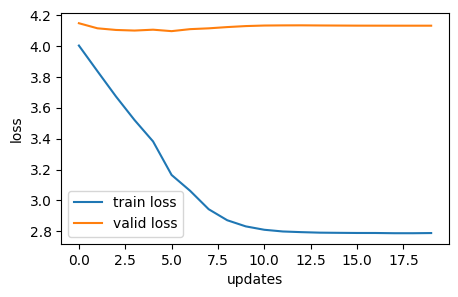

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [ ]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_data, criterion, batch_size, seq_len, device)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.096 | Test PPL:  60.082 |


## 7. Real-world inference

Here we take the prompt, tokenize, encode and feed it into the model to get the predictions.  We then apply softmax while specifying that we want the output due to the last word in the sequence which represents the prediction for the next word.  We divide the logits by a temperature value to alter the model’s confidence by adjusting the softmax probability distribution.

Once we have the Softmax distribution, we randomly sample it to make our prediction on the next word. If we get <unk> then we give that another try.  Once we get <eos> we stop predicting.
    
We decode the prediction back to strings last lines.

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, device, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    model.eval()
    tokens = tokenizer(prompt)
    indices = [vocab[t] for t in tokens]
    batch_size = 1
    # hidden = model.init_hidden(batch_size, device)
    with torch.no_grad():
        for i in range(max_seq_len):
            src = torch.LongTensor([indices]).to(device)
            prediction, hidden = model(src)

            # print(prediction.shape)
            #prediction: [batch size, seq len, vocab size]
            #prediction[:, -1]: [batch size, vocab size] #probability of last vocab
            
            probs = torch.softmax(prediction[:, -1] / temperature, dim=-1)  
            prediction = torch.multinomial(probs, num_samples=1).item()    
            
            while prediction == vocab['<unk>']: #if it is unk, we sample again
                prediction = torch.multinomial(probs, num_samples=1).item()

            if prediction == vocab['<eos>']:    #if it is eos, we stop
                break

            indices.append(prediction) #autoregressive, thus output becomes input

    itos = vocab.get_itos()
    tokens = [itos[i] for i in indices]
    return tokens

In [ ]:
prompt = 'he lost the key'
max_seq_len = 30
seed = 0
            #superdiverse   more diverse
temperatures = [0.5, 0.7, 0.75, 0.8, 1.0] 
#sample from this distribution higher probability will get more change
for temperature in temperatures:
    generation = generate(prompt, max_seq_len, temperature, model, tokenizer, 
                          vocab_transform, device, seed)
    print(str(temperature)+'\n'+' '.join(generation)+'\n')

0.5
he lost the key to the cellar

0.7
he lost the key

0.75
he lost the key

0.8
he lost the key

1.0
he lost the key amid the awesome and unnatural hold of a shocking

